## ROC Plot: HMMER vs MMseqs vs MMore

## PROFMARK dataset - Parameter Search
### Profile-to-Sequence 

In [76]:
#imports
from __future__ import print_function
import sys
import os
import psutil
import math
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
from IPython.display import display
from matplotlib import cm as cmap
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import statsmodels.api as sm
import statistics as stats

In [77]:
# number or rows/columns to display
pd.options.display.max_rows = 40
pd.options.display.max_columns = 20

# resolution of output
matplotlib.rcParams['figure.dpi'] = 300

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 6 }

matplotlib.rc('font', **font)

In [78]:
# root directory
path_to_db = "data/profmark/"

In [79]:
# index filepaths
target_index_fname = "{}/pmark.hmm.idx".format(path_to_db)
query_index_fname = "{}/pmark.fa.idx".format(path_to_db)

In [80]:
fnames = []

# options
my_kscores  = ["k75", "k80", "k95"]
my_alphas   = ["12", "16"]
my_betas    = ["24", "32", "40"]
my_evals    = ["e1000"]
my_biascorr = ["bias", "nobias"]
my_id       = ["001", "003"]

# hmmer
hmmer = {}
hmmer["fname"] = "{}/hmmer.profmark.p2s.003.tf".format(path_to_db)

# mmseqs
my_id = "003"
mmseqs = {}
for K in my_kscores:
    fname = "{}/mmseqs.profmark.p2s.{}.{}.tf".format(path_to_db, K, my_id)
    mmseqs[K] = {}
    mmseqs[K]["fname"] = fname
    
    fnames.append(fname)
pass

# mmore
mmore = {}
my_id = "006"
for K in my_kscores:
#     print("KSCORE: {}".format(K))
    mmore[K] = {}
    for A in my_alphas:
#         print("\tALPHA: {}".format(A))
        mmore[K][A] = {}
        for B in my_betas:
#             print("\t\tBETA: {}".format(B))
            mmore[K][A][B] = {}
            for E in my_evals:
#                 print("\t\t\tEVAL: {}".format(E))
                mmore[K][A][B][E] = {}
    
                fname = "{}/mmore.profmark.p2s.{}.{}.{}.{}.{}.tf".format(path_to_db, K, A, B, E, my_id)
                mmore[K][A][B][E]["fname"] = fname
                fnames.append(fname)
            
                fname = "{}/mmore.profmark.p2s.{}.{}.{}.{}.{}.nobias.tf".format(path_to_db, K, A, B, E, my_id)
                mmore[K][A][B][E]["nobias-fname"] = fname
                fnames.append(fname)
            pass
        pass
    pass
pass


In [81]:
fnames

['data/profmark//mmseqs.profmark.p2s.k75.003.tf',
 'data/profmark//mmseqs.profmark.p2s.k80.003.tf',
 'data/profmark//mmseqs.profmark.p2s.k95.003.tf',
 'data/profmark//mmore.profmark.p2s.k75.12.24.e1000.006.tf',
 'data/profmark//mmore.profmark.p2s.k75.12.24.e1000.006.nobias.tf',
 'data/profmark//mmore.profmark.p2s.k75.12.32.e1000.006.tf',
 'data/profmark//mmore.profmark.p2s.k75.12.32.e1000.006.nobias.tf',
 'data/profmark//mmore.profmark.p2s.k75.12.40.e1000.006.tf',
 'data/profmark//mmore.profmark.p2s.k75.12.40.e1000.006.nobias.tf',
 'data/profmark//mmore.profmark.p2s.k75.16.24.e1000.006.tf',
 'data/profmark//mmore.profmark.p2s.k75.16.24.e1000.006.nobias.tf',
 'data/profmark//mmore.profmark.p2s.k75.16.32.e1000.006.tf',
 'data/profmark//mmore.profmark.p2s.k75.16.32.e1000.006.nobias.tf',
 'data/profmark//mmore.profmark.p2s.k75.16.40.e1000.006.tf',
 'data/profmark//mmore.profmark.p2s.k75.16.40.e1000.006.nobias.tf',
 'data/profmark//mmore.profmark.p2s.k80.12.24.e1000.006.tf',
 'data/profmark

In [82]:
# Total Queries and Targets
total_target       =    211547
total_query        =      2141
total_target_real  =     11547 
total_target_decoy =    200000
# Total True Positives and Negatives
total_res = 452922127
total_TP  =     11547
total_TN  = 428200000
unknown   =  24710580
TP_to_TN  =  2.70e-05

# load data

In [83]:
datas = []

# set header format
tf_dformat = {
    "target_name": "str",
    "query_name": "str",
    "eval": "float",
    "truth": "str",
    "tot_T": "int",
    "tot_F": "int",
    "tot_?": "int"
}
tf_header = tf_dformat.keys()

# load data
usecols = [0,1,2,3,4,5]
skiprows = None
sep = " "
names = tf_header

In [84]:
hmmer["data"]  = pd.read_csv( hmmer["fname"], sep=sep, header=None, skiprows=skiprows, usecols=usecols, names=names, index_col=False, verbose=False )
hmmer["color"] = "black"
hmmer["label"] = "hmmer"
datas.append(hmmer["data"])

In [85]:
my_kcolors = ["pink", "red", "maroon"]

for i,K in enumerate(my_kscores):
    data = pd.read_csv( mmseqs[K]["fname"], sep=sep, header=None, skiprows=skiprows, usecols=usecols, names=names, index_col=False, verbose=False, error_bad_lines=False )
    mmseqs[K]["data"] = data
    mmseqs[K]["color"] = my_kcolors[i] 
    mmseqs[K]["label"] = "mmseqs-{}".format(K)
    datas.append(mmseqs[K]["data"])
pass

In [86]:
for K in my_kscores:
    for A in my_alphas:
        for B in my_betas:
            for E in my_evals:
                data = pd.read_csv( mmore[K][A][B][E]["fname"], sep=sep, header=None, skiprows=skiprows, usecols=usecols, names=names, index_col=False, verbose=False, error_bad_lines=False )
                mmore[K][A][B][E]["data"] = data
                mmore[K][A][B][E]["label"] = "mmore-{}-{}-{}-{}".format(K, A, B, E)
                datas.append(mmore[K][A][B][E]["data"])
                
                data = pd.read_csv( mmore[K][A][B][E]["nobias-fname"], sep=sep, header=None, skiprows=skiprows, usecols=usecols, names=names, index_col=False, verbose=False, error_bad_lines=False )
                mmore[K][A][B][E]["nobias-data"] = data
                mmore[K][A][B][E]["nobias-label"] = "mmore-{}-{}-{}-{}-nobias".format(K, A, B, E)
                datas.append(mmore[K][A][B][E]["nobias-data"])
            pass
        pass
    pass
pass

In [87]:
for data in datas:
    data["roc_y"] = data["tot_T"] / total_TP
#     data["roc_x"] = data["tot_F"] / total_query    
    data["roc_x"] = data["tot_F"]

In [88]:
data

,target_name,query_name,eval,truth,tot_T,tot_F,roc_y,roc_x
0,FragX_IP,decoy97338,-14.034,F,0,1,0.000000,1
1,DUF3414,decoy120747,-13.777,F,0,2,0.000000,2
2,DUF3414,decoy26206,-13.554,F,0,3,0.000000,3
3,Herpes_UL36,decoy96841,-13.465,F,0,4,0.000000,4
4,DUF2186,decoy92849,-13.428,F,0,5,0.000000,5
...,...,...,...,...,...,...,...,...
65774,DUF3414,DUF3414/3370/56-1698/2027-3618,495.425,T,6356,54411,0.550446,54411
65775,DUF3414,DUF3414/3369/134-1775/1798-3786,550.874,T,6357,54411,0.550533,54411
65776,Exonuc_V_gamma,Exonuc_V_gamma/4164/404-1535/1913-2938,567.028,T,6358,54411,0.550619,54411
65777,DUF3414,DUF3414/3365/148-1852/2031-3678,718.836,T,6359,54411,0.550706,54411


In [89]:
# set colors
hmmer["color"] = "black"

mmseqs["k95"]["color"] = "pink"
mmseqs["k80"]["color"] = "red"
mmseqs["k75"]["color"] = "maroon"

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


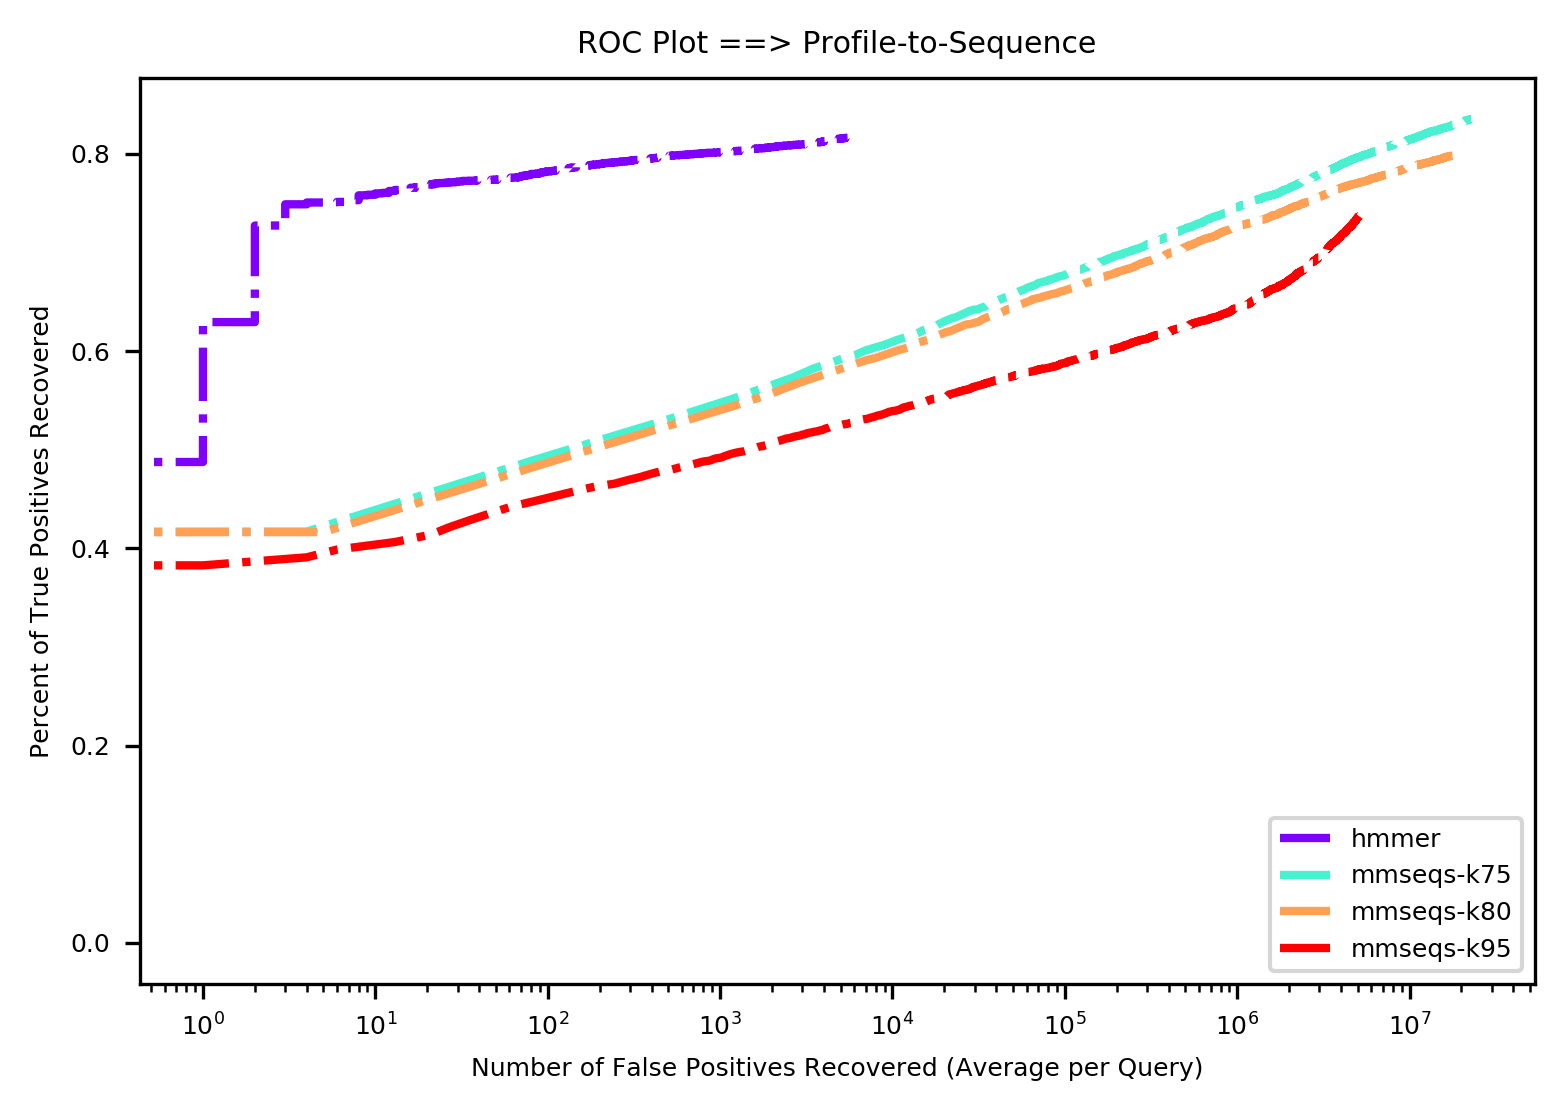

In [90]:
my_data   = []
my_colors = []
my_labels = []

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )

for K in my_kscores:
    my_data.append( mmseqs[K]["data"] )
    my_colors.append( mmseqs[K]["color"] )
    my_labels.append( mmseqs[K]["label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

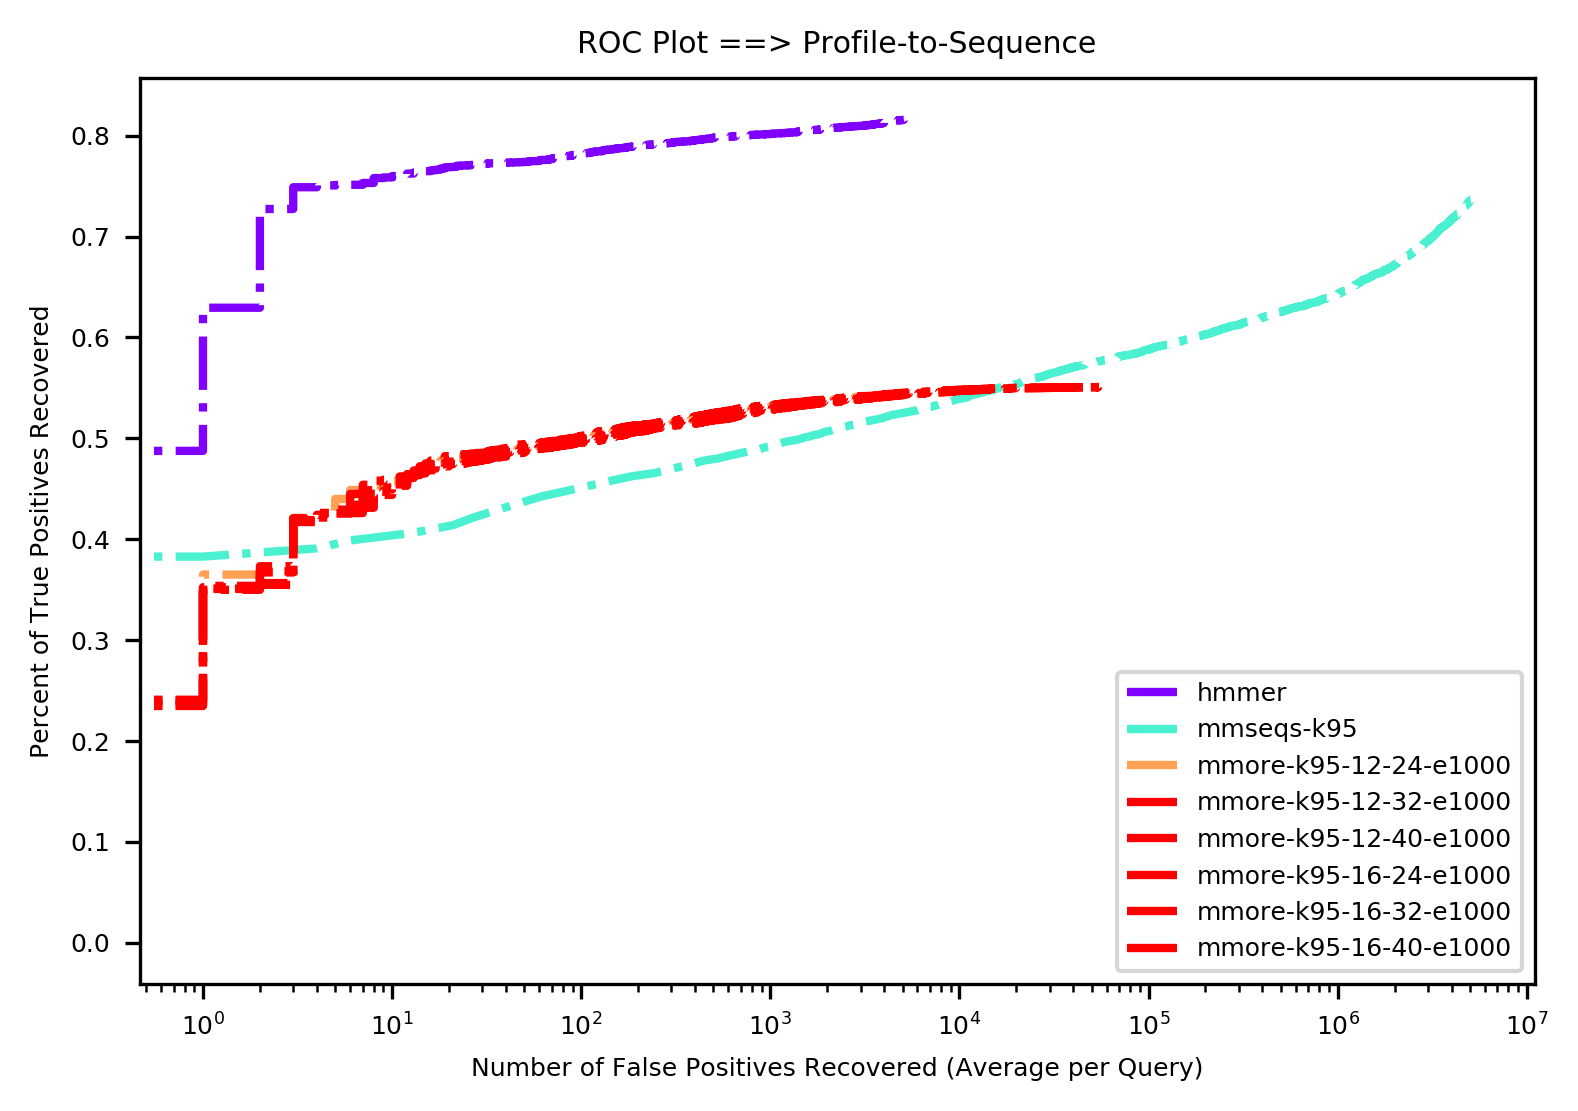

In [92]:
my_data = []
my_colors = []
my_labels = []

i = 2
K = my_kscores[i]
A = my_alphas[0]
B = my_betas[0]
E = my_evals[0]

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )
    
my_data.append( mmseqs[K]["data"] )
my_colors.append( mmseqs[K]["color"] )
my_labels.append( mmseqs[K]["label"] )

# for Ai in my_alphas:
#     for Bi in my_betas:
#         my_data.append( mmore[K][Ai][Bi][E]["nobias-data"] )
#         my_colors.append( 'black' )
#         my_labels.append( mmore[K][Ai][Bi][E]["nobias-label"] )

for Ai in my_alphas:
    for Bi in my_betas:
        my_data.append( mmore[K][Ai][Bi][E]["data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

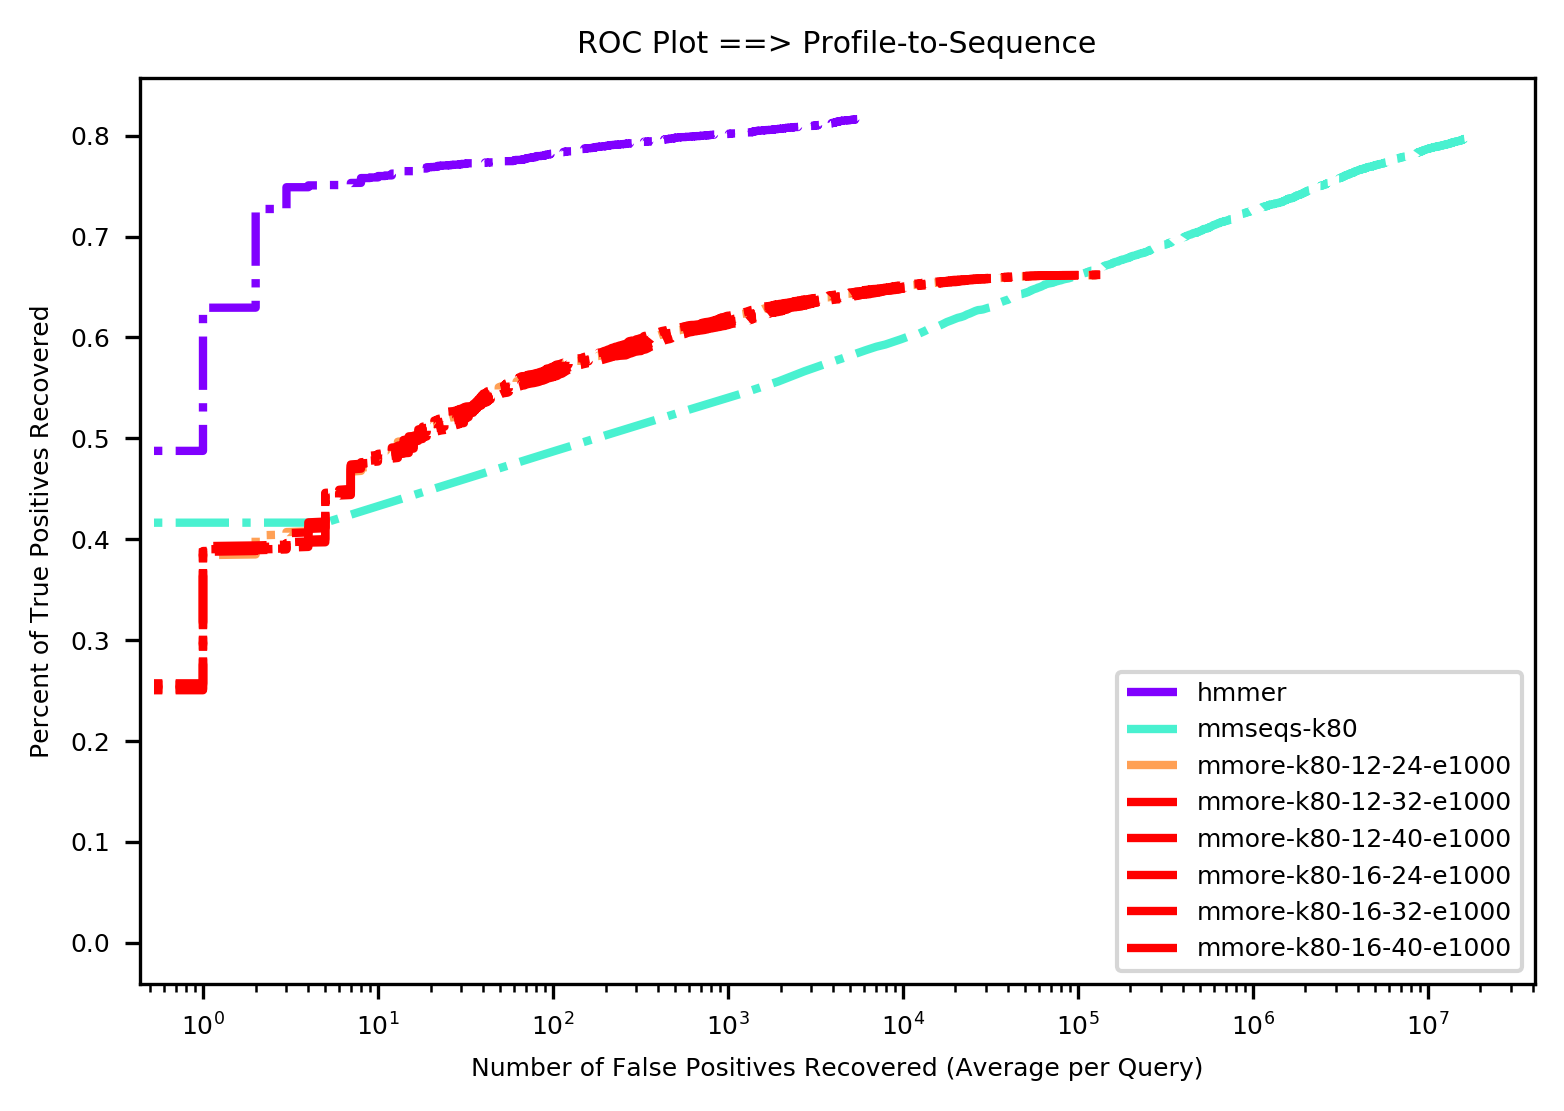

In [74]:
my_data = []
my_colors = []
my_labels = []

i = 1
K = my_kscores[i]
A = my_alphas[0]
B = my_betas[0]
E = my_evals[0]

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )
    
my_data.append( mmseqs[K]["data"] )
my_colors.append( mmseqs[K]["color"] )
my_labels.append( mmseqs[K]["label"] )

# for Ai in my_alphas:
#     for Bi in my_betas:
#         my_data.append( mmore[K][Ai][Bi][E]["nobias-data"] )
#         my_colors.append( 'black' )
#         my_labels.append( mmore[K][Ai][Bi][E]["nobias-label"] )

for Ai in my_alphas:
    for Bi in my_betas:
        my_data.append( mmore[K][Ai][Bi][E]["data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

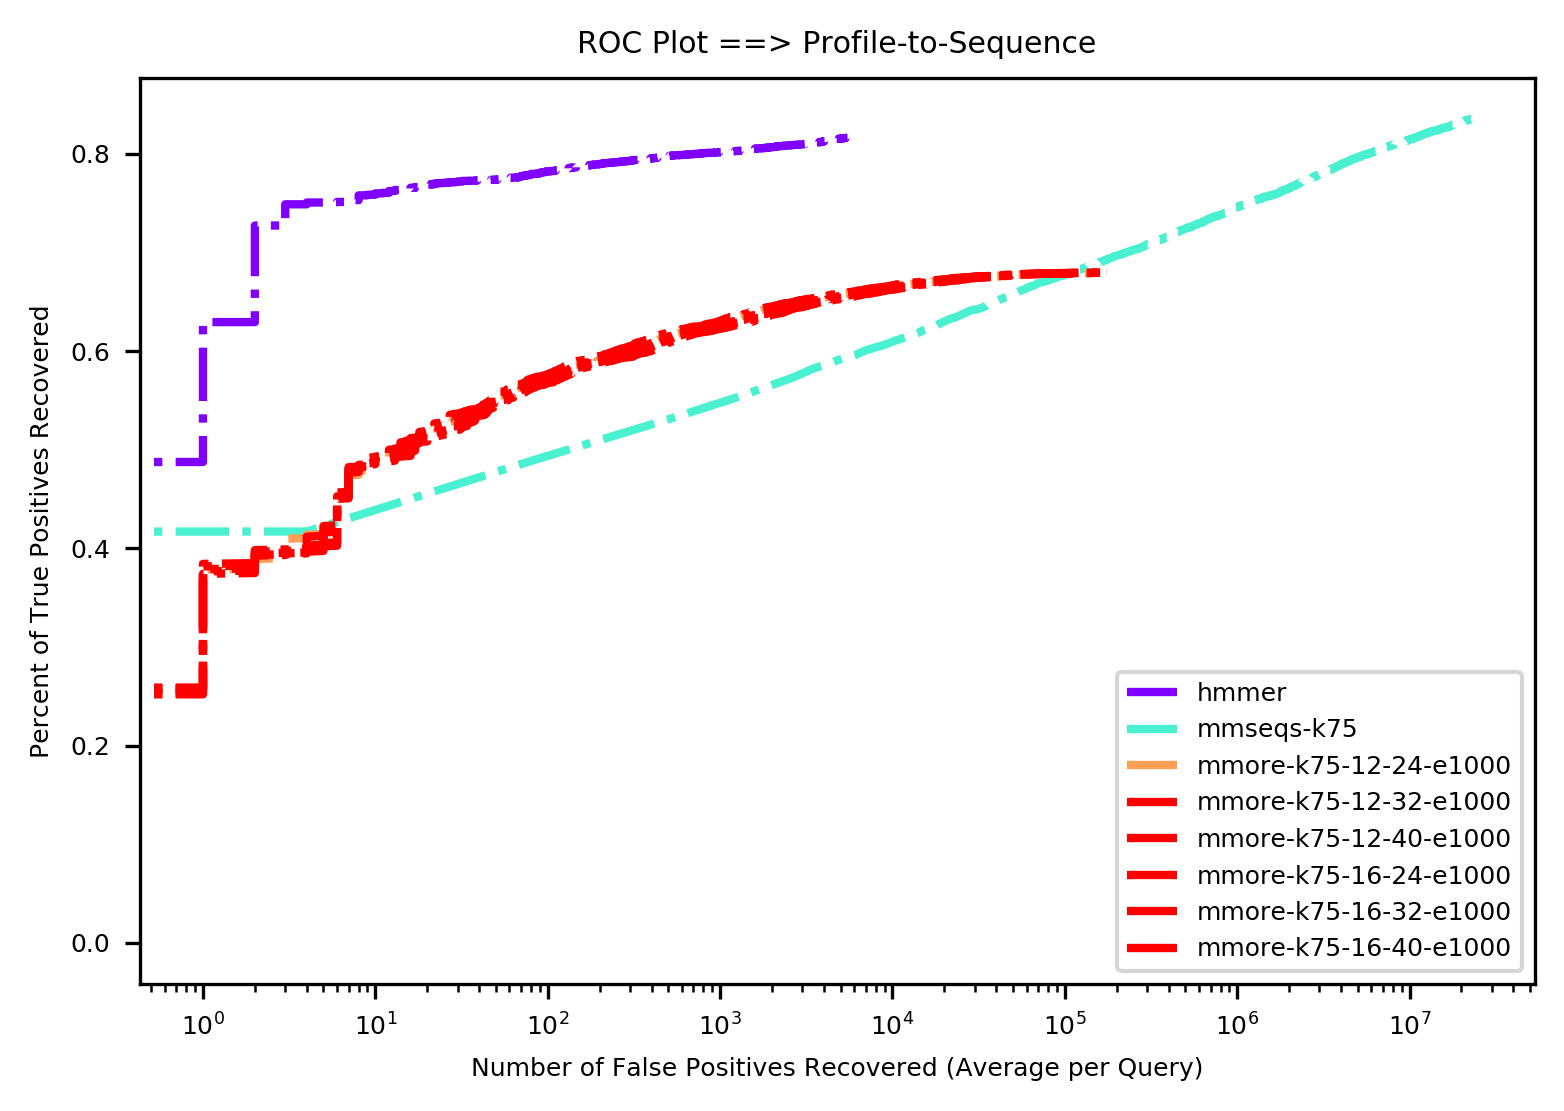

In [75]:
my_data = []
my_colors = []
my_labels = []

i = 0
K = my_kscores[i]
A = my_alphas[0]
B = my_betas[0]
E = my_evals[0]

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )
    
my_data.append( mmseqs[K]["data"] )
my_colors.append( mmseqs[K]["color"] )
my_labels.append( mmseqs[K]["label"] )

for Ai in my_alphas:
    for Bi in my_betas:
        my_data.append( mmore[K][Ai][Bi][E]["data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

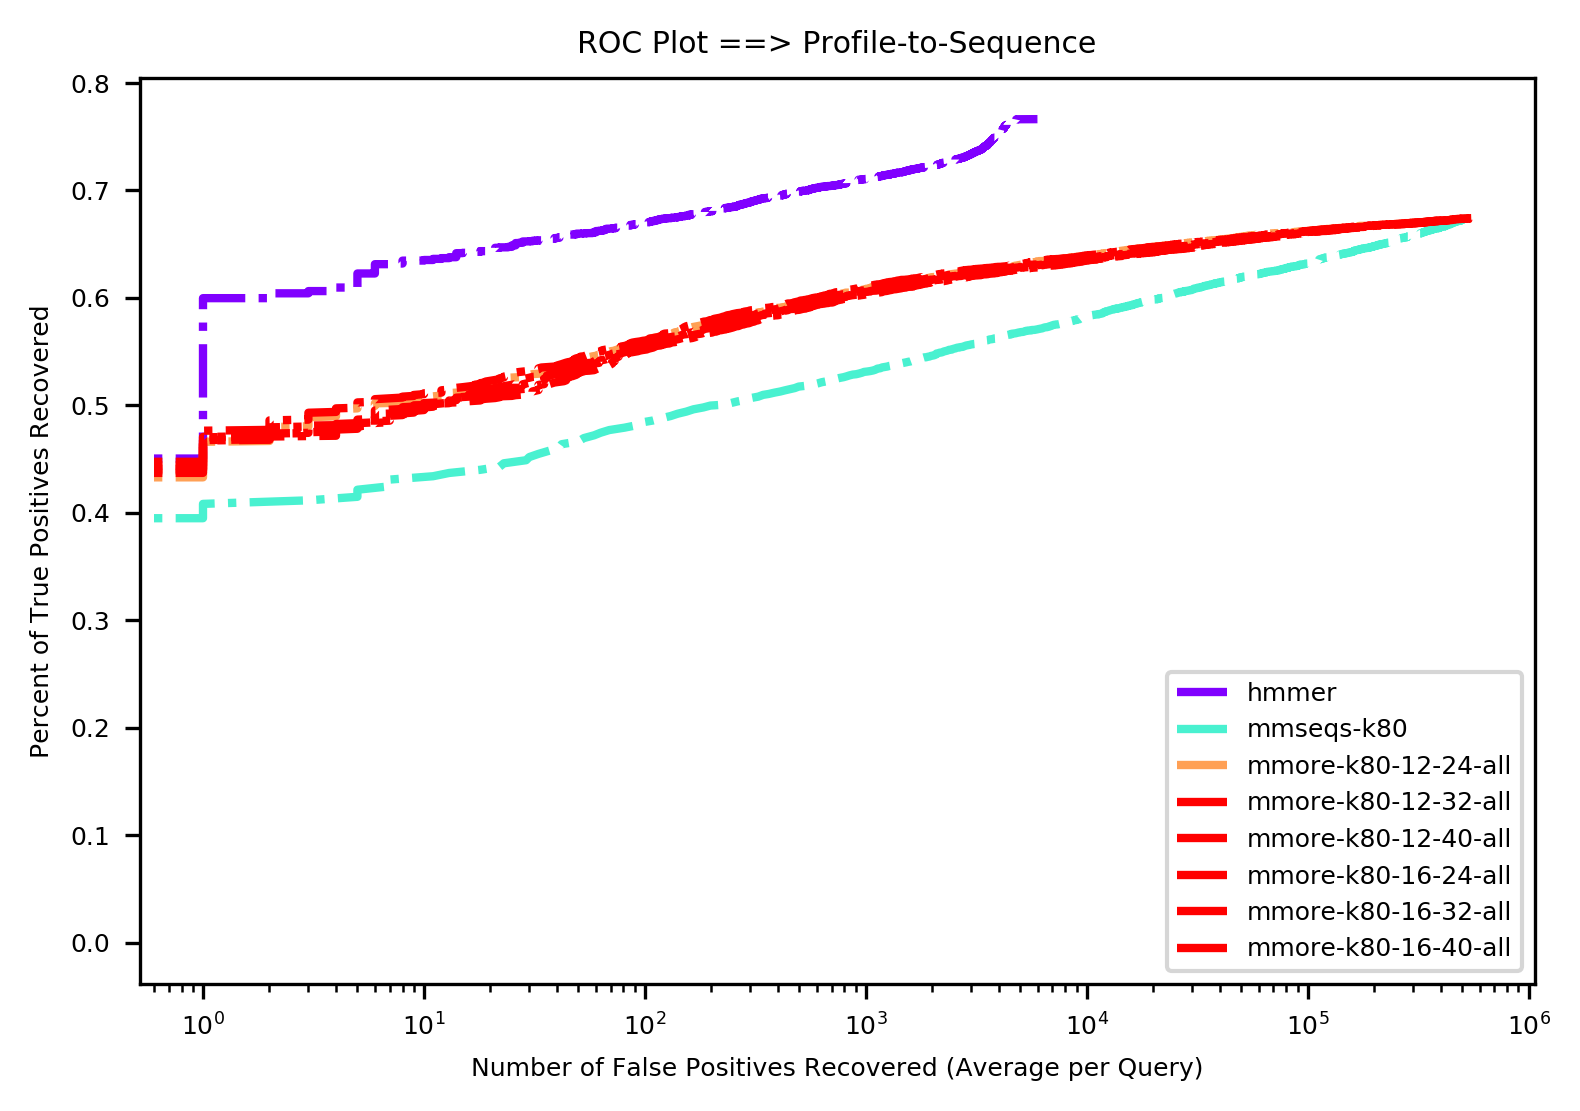

In [482]:
my_data = []
my_colors = []
my_labels = []

i = 1
K = my_kscores[i]
A = my_alphas[0]
B = my_betas[0]
E = my_evals[0]

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )
    
my_data.append( mmseqs[K]["data"] )
my_colors.append( mmseqs[K]["color"] )
my_labels.append( mmseqs[K]["label"] )

for Ai in my_alphas:
    for Bi in my_betas:
        my_data.append( mmore[K][Ai][Bi][E]["data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

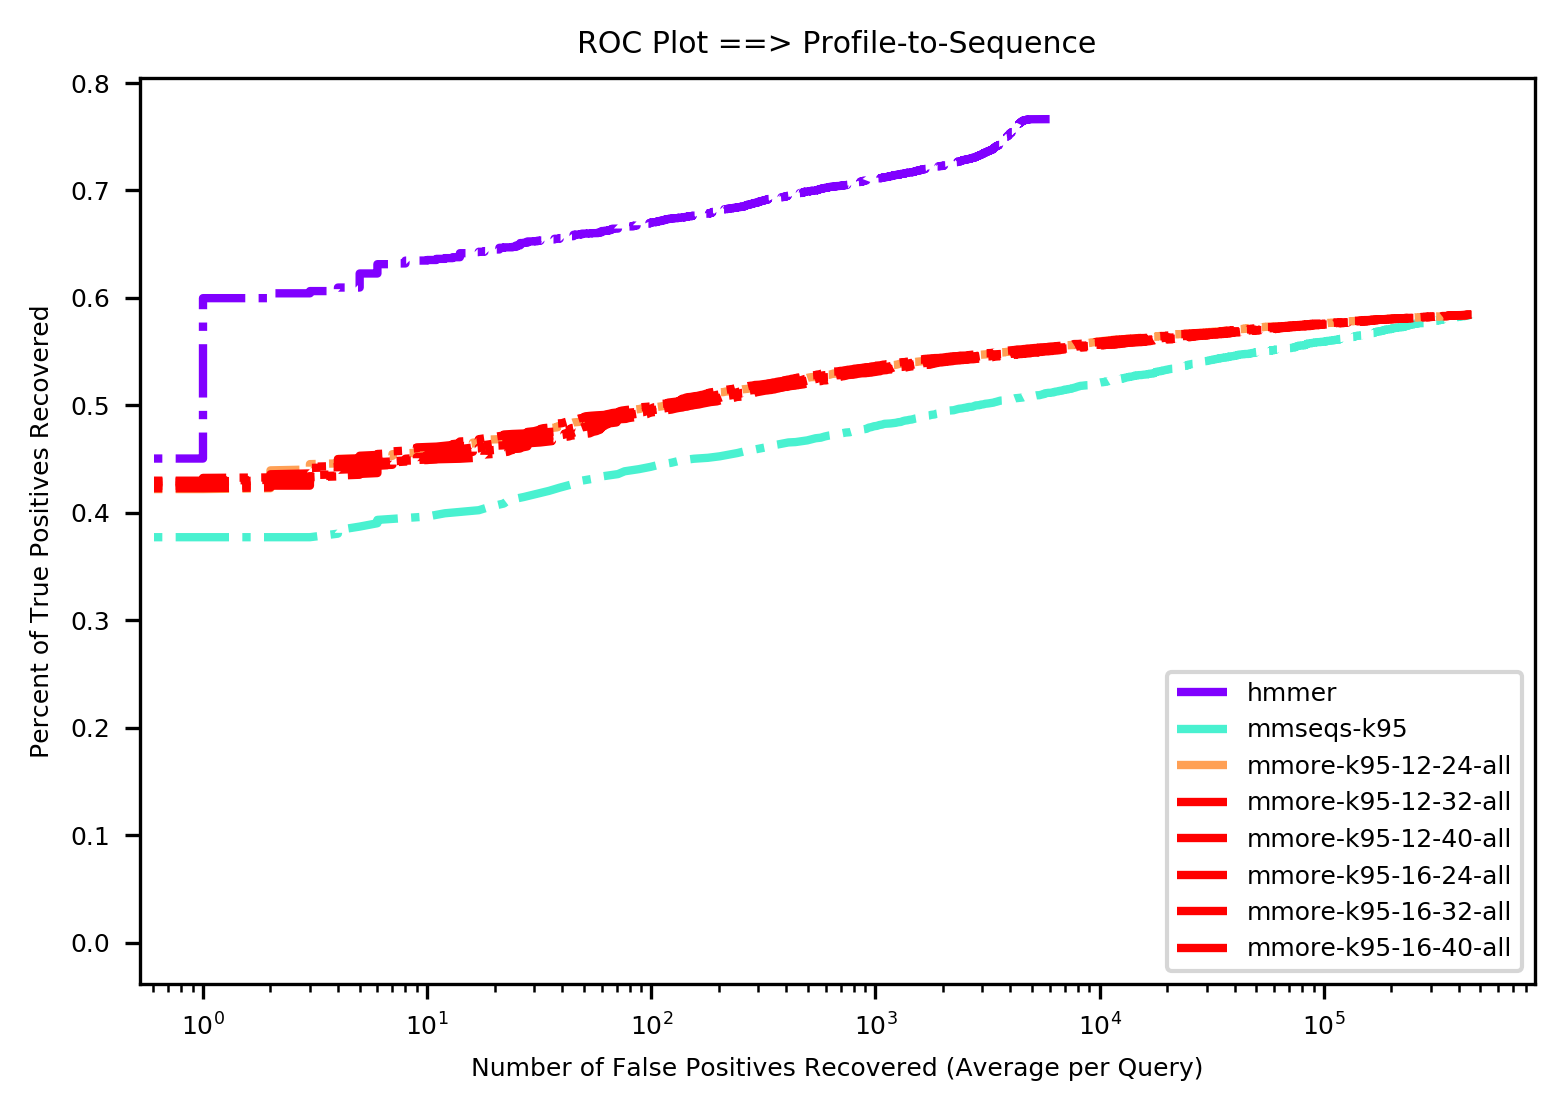

In [483]:
my_data = []
my_colors = []
my_labels = []

i = 2
K = my_kscores[i]
A = my_alphas[0]
B = my_betas[0]
E = my_evals[0]

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )
    
my_data.append( mmseqs[K]["data"] )
my_colors.append( mmseqs[K]["color"] )
my_labels.append( mmseqs[K]["label"] )

for Ai in my_alphas:
    for Bi in my_betas:
        my_data.append( mmore[K][Ai][Bi][E]["data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

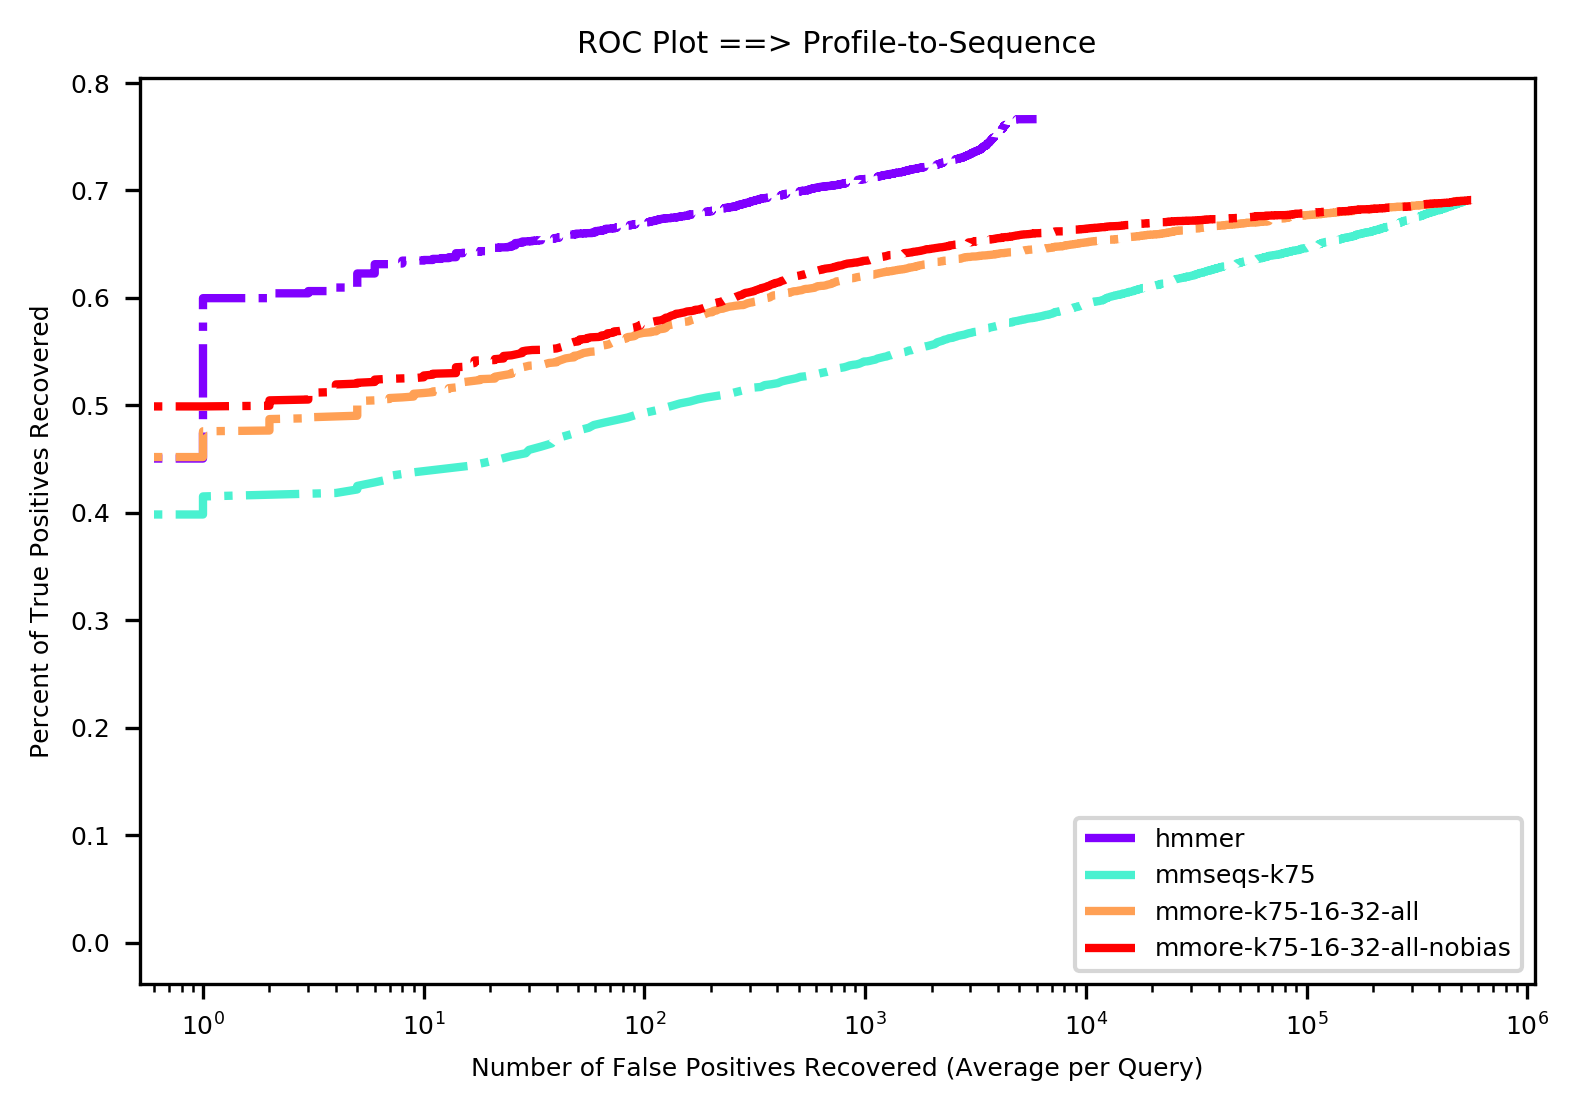

In [487]:
my_data = []
my_colors = []
my_labels = []

i = 0
K = my_kscores[i]
A = my_alphas[0]
B = my_betas[0]
E = my_evals[0]

my_data.append( hmmer["data"] )
my_colors.append( hmmer["color"] )
my_labels.append( hmmer["label"] )
    
my_data.append( mmseqs[K]["data"] )
my_colors.append( mmseqs[K]["color"] )
my_labels.append( mmseqs[K]["label"] )

for Ai in ["16"]:
    for Bi in ["32"]:
        my_data.append( mmore[K][Ai][Bi][E]["data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["label"] )
        
        my_data.append( mmore[K][Ai][Bi][E]["nobias-data"] )
        my_colors.append( 'black' )
        my_labels.append( mmore[K][Ai][Bi][E]["nobias-label"] )

for x in range(len(my_data)):
    my_colors[x] = cmap.rainbow(x*100)
    plt.plot( my_data[x]["roc_x"], my_data[x]["roc_y"], color=my_colors[x], label=my_labels[x], linestyle="-.", linewidth=2, marker=None )

plt.title('ROC Plot ==> Profile-to-Sequence')
plt.legend(loc='lower right')
plt.ylabel('Percent of True Positives Recovered')
plt.xlabel('Number of False Positives Recovered (Average per Query)')
plt.xscale('log')
plt.savefig("visuals/mmseqs-hmmer-fbpruner-roc-plot.svg")
plt.show()

In [389]:
c = {}
for i in range(100):
    c[i] = cmap.rainbow(i)
    print("c[{}]: {}".format(i, c[i]))

# object_methods = [method_name for method_name in dir(cmap)
#                   if callable(getattr(cmap, method_name))]

# print(object_methods)

c[0]: (0.5, 0.0, 1.0, 1.0)
c[1]: (0.49215686274509807, 0.012319659535238442, 0.9999810273487268, 1.0)
c[2]: (0.4843137254901961, 0.02463744919538197, 0.9999241101148306, 1.0)
c[3]: (0.4764705882352941, 0.03695149938914489, 0.9998292504580527, 1.0)
c[4]: (0.46862745098039216, 0.04925994109281685, 0.9996964519778716, 1.0)
c[5]: (0.4607843137254902, 0.061560906133942835, 0.9995257197133659, 1.0)
c[6]: (0.45294117647058824, 0.07385252747487396, 0.9993170601430229, 1.0)
c[7]: (0.44509803921568625, 0.08613293949614599, 0.9990704811844932, 1.0)
c[8]: (0.4372549019607843, 0.0984002782796427, 0.99878599219429, 1.0)
c[9]: (0.4294117647058824, 0.11065268189150083, 0.9984636039674339, 1.0)
c[10]: (0.4215686274509804, 0.12288829066471411, 0.9981033287370441, 1.0)
c[11]: (0.4137254901960784, 0.13510524748139296, 0.9977051801738729, 1.0)
c[12]: (0.40588235294117647, 0.1473016980546375, 0.997269173385788, 1.0)
c[13]: (0.39803921568627454, 0.1594757912099808, 0.9967953249171991, 1.0)
c[14]: (0.39019607